In [ ]:
# 📦 Install required packages if not already installed
!pip install xgboost openpyxl

# 📚 Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 🔽 Load Excel file from specified path
file_path = "/content/WPI_Master-dataset.xlsx"
df = pd.read_excel(file_path)

In [ ]:
# 🧹 Rename and clean
df = df.rename(columns={
    'Date': 'Date',
    'WPI (stainless)': 'WPI_Stainless',
    'WPI (mild flat)': 'WPI_MildFlat',
    'WPI (mild long)': 'WPI_MildLong',
    'WPI (Crude Petroleum)': 'WPI_CrudePetroleum',
    'WPI (Iron Ore)': 'WPI_IronOre',
    'WPI (Coking Coal)': 'WPI_CokingCoal',
    'WPI (non-ferrous metals)': 'WPI_NonFerrous',
    '(IIP 24th col)': 'IIP_Metals',
    '(IIP 25th col)': 'IIP_Machinery',
    'Manufacturing PMI': 'Manufacturing_PMI',
    'Avg. USD/INR': 'USD_INR',
    'Inflation Rate (%)': 'InflationRate',
    'Crude Steel Prod (MnT)': 'CrudeSteel_MnT',
    'Finished Steel Prod (MnT)': 'FinishedSteel_MnT',
    'Import (MnT)': 'Import_MnT',
    'Export (MnT)': 'Export_MnT',
    'Consumption (MnT)': 'Consumption_MnT',
    '(SHFE)': 'SHFE',
    '(Mild Steel Futures)': 'MildSteelFutures',
    '(WPI cement)': 'WPI_Cement'
})
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [ ]:
# 🎯 Targets and Features
targets = ['WPI_Stainless', 'WPI_MildFlat', 'WPI_MildLong']
features = [
    'USD_INR', 'Consumption_MnT', 'FinishedSteel_MnT',
    'CrudeSteel_MnT', 'Manufacturing_PMI', 'SHFE', 'MildSteelFutures',
    'WPI_CrudePetroleum', 'InflationRate', 'IIP_Machinery', 'Import_MnT',
    'Export_MnT', 'WPI_Cement'
]


In [ ]:
# ➕ Add lag features
for col in features:
    df[f"{col}_lag1"] = df[col].shift(1)
df = df.dropna()

In [ ]:
# 🧮 Prepare training data
X = df[[f"{col}_lag1" for col in features]]
y_stainless = df['WPI_Stainless']
y_mildflat = df['WPI_MildFlat']
y_mildlong = df['WPI_MildLong']

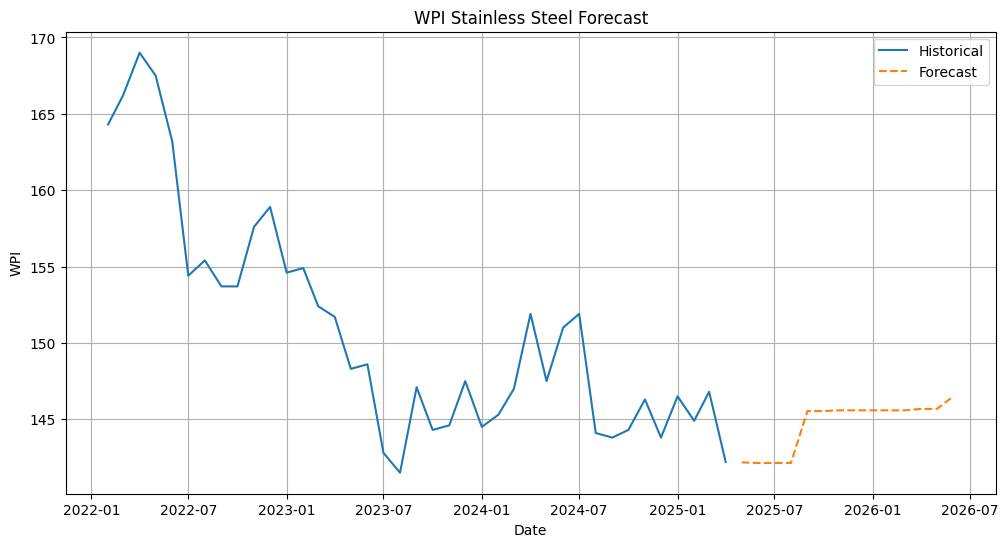

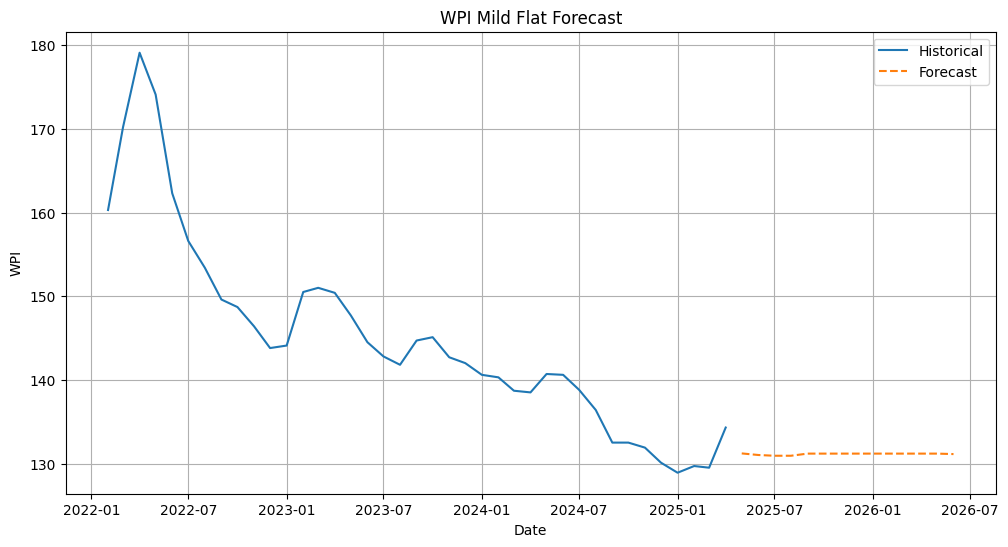

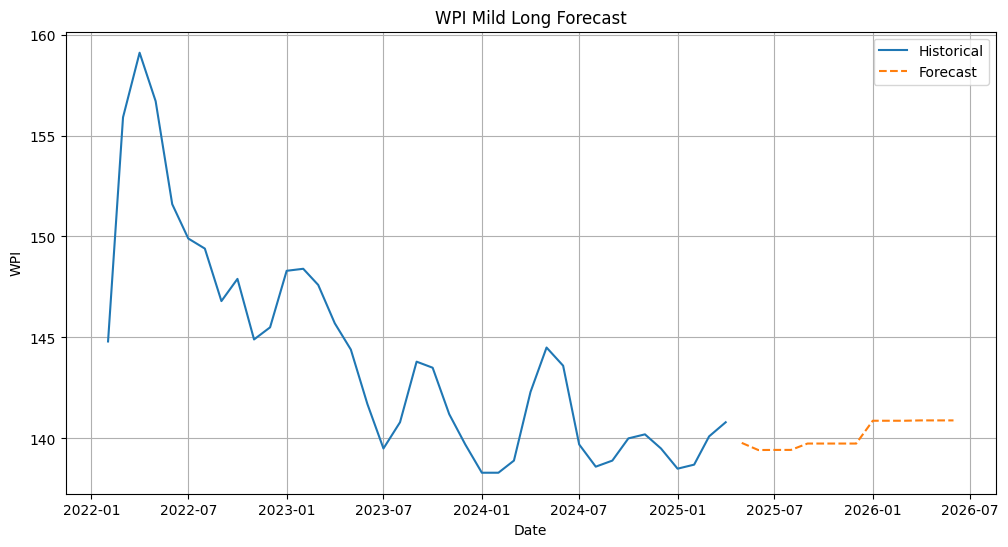

In [ ]:
# 🔢 Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🤖 Train XGBoost models
model_s = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_f = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_l = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_s.fit(X_scaled, y_stainless)
model_f.fit(X_scaled, y_mildflat)
model_l.fit(X_scaled, y_mildlong)

# ⏳ Forecast inputs from May 2025 to June 2026
future_dates = pd.date_range(start='2025-05-01', end='2026-06-01', freq='MS')
forecast_df = pd.DataFrame(index=future_dates)

for col in features:
    ts = df[col]
    trend_model = LinearRegression().fit(np.arange(len(ts)).reshape(-1, 1), ts.values)
    future_time = np.arange(len(ts), len(ts) + len(future_dates)).reshape(-1, 1)
    forecast_df[f"{col}_lag1"] = trend_model.predict(future_time)

# 🔢 Standardize future inputs
X_future = scaler.transform(forecast_df)

# 🔮 Forecast WPI values
forecast_stainless = model_s.predict(X_future)
forecast_mildflat = model_f.predict(X_future)
forecast_mildlong = model_l.predict(X_future)

# 📊 Create result DataFrame
result_df = pd.DataFrame({
    'WPI_Stainless_Forecast': forecast_stainless,
    'WPI_MildFlat_Forecast': forecast_mildflat,
    'WPI_MildLong_Forecast': forecast_mildlong
}, index=future_dates)

# 📈 Plotting
def plot_forecast(hist, forecast, label):
    plt.figure(figsize=(12, 6))
    plt.plot(hist, label="Historical")
    plt.plot(result_df.index, forecast, linestyle='--', label="Forecast")
    plt.title(f"{label} Forecast")
    plt.xlabel("Date")
    plt.ylabel("WPI")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_forecast(df['WPI_Stainless'], result_df['WPI_Stainless_Forecast'], "WPI Stainless Steel")
plot_forecast(df['WPI_MildFlat'], result_df['WPI_MildFlat_Forecast'], "WPI Mild Flat")
plot_forecast(df['WPI_MildLong'], result_df['WPI_MildLong_Forecast'], "WPI Mild Long")

In [ ]:
# 🖨️ Print WPI forecast table for May 2025 to May 2026
print("📅 WPI Forecasts (May 2025 to May 2026):")
display(result_df.round(2).head(13))


📅 WPI Forecasts (May 2025 to May 2026):


,WPI_Stainless_Forecast,WPI_MildFlat_Forecast,WPI_MildLong_Forecast
2025-05-01,142.179993,131.210007,139.779999
2025-06-01,142.139999,131.020004,139.419998
2025-07-01,142.139999,130.929993,139.429993
2025-08-01,142.139999,130.929993,139.429993
2025-09-01,145.539993,131.179993,139.740005
2025-10-01,145.539993,131.179993,139.740005
2025-11-01,145.580002,131.179993,139.740005
2025-12-01,145.580002,131.179993,139.740005
2026-01-01,145.580002,131.179993,140.869995
2026-02-01,145.580002,131.179993,140.869995


In [ ]:
print(df.columns.tolist())

['WPI_Stainless', 'WPI_MildFlat', 'WPI_MildLong', 'WPI_CrudePetroleum', 'WPI_IronOre', 'WPI_CokingCoal', 'WPI_NonFerrous', 'IIP_Metals', 'IIP_Machinery', 'Manufacturing_PMI', 'USD_INR', 'InflationRate', 'CrudeSteel_MnT', 'FinishedSteel_MnT', 'Import_MnT', 'Export_MnT', 'Consumption_MnT', 'SHFE', 'MildSteelFutures', 'WPI_Cement', 'USD_INR_lag1', 'Consumption_MnT_lag1', 'FinishedSteel_MnT_lag1', 'CrudeSteel_MnT_lag1', 'Manufacturing_PMI_lag1', 'SHFE_lag1', 'MildSteelFutures_lag1', 'WPI_CrudePetroleum_lag1', 'InflationRate_lag1', 'IIP_Machinery_lag1', 'Import_MnT_lag1', 'Export_MnT_lag1', 'WPI_Cement_lag1']


Training SARIMA model for WPI_Stainless...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Training SARIMA model for WPI_MildFlat...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Training SARIMA model for WPI_MildLong...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


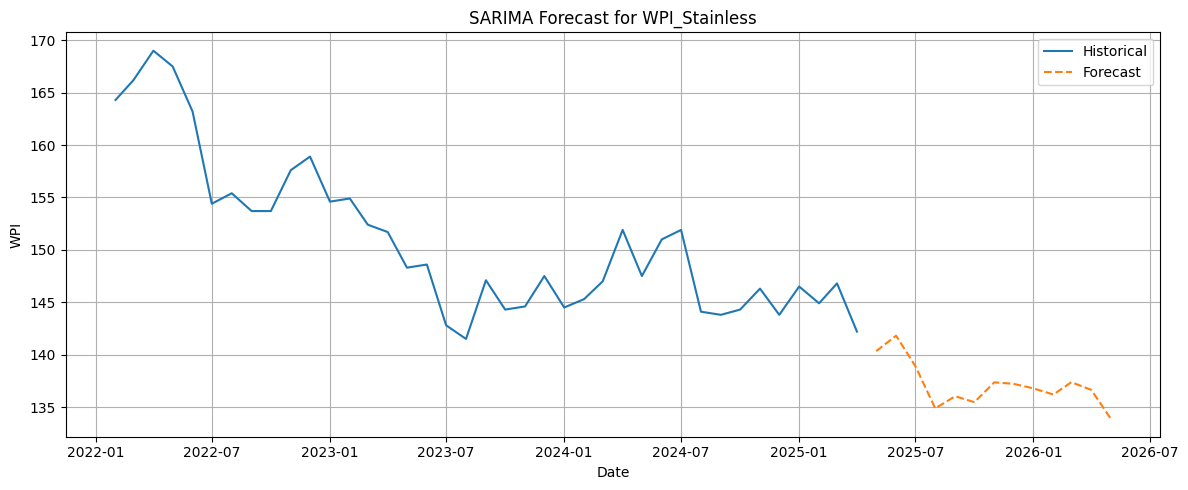

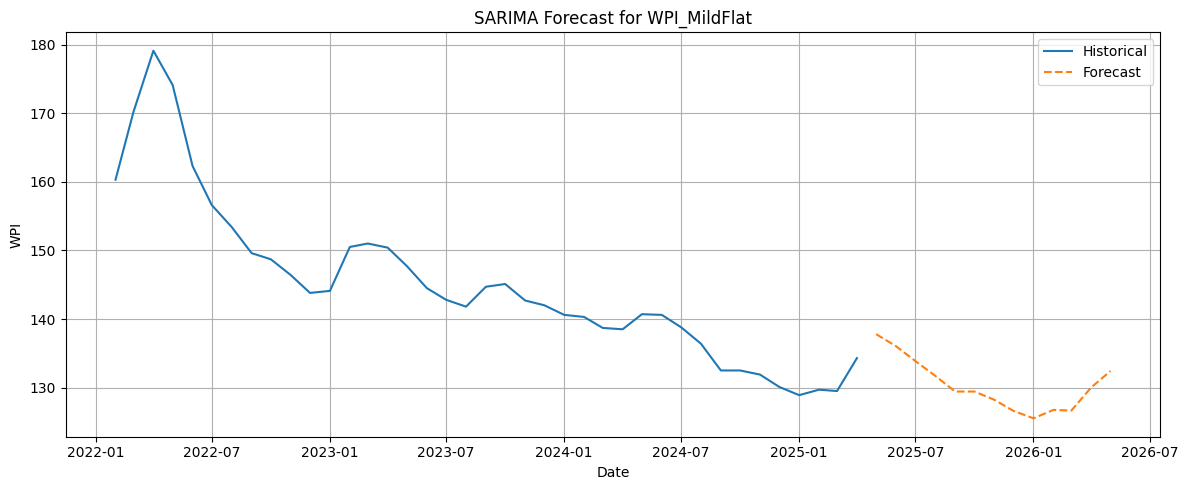

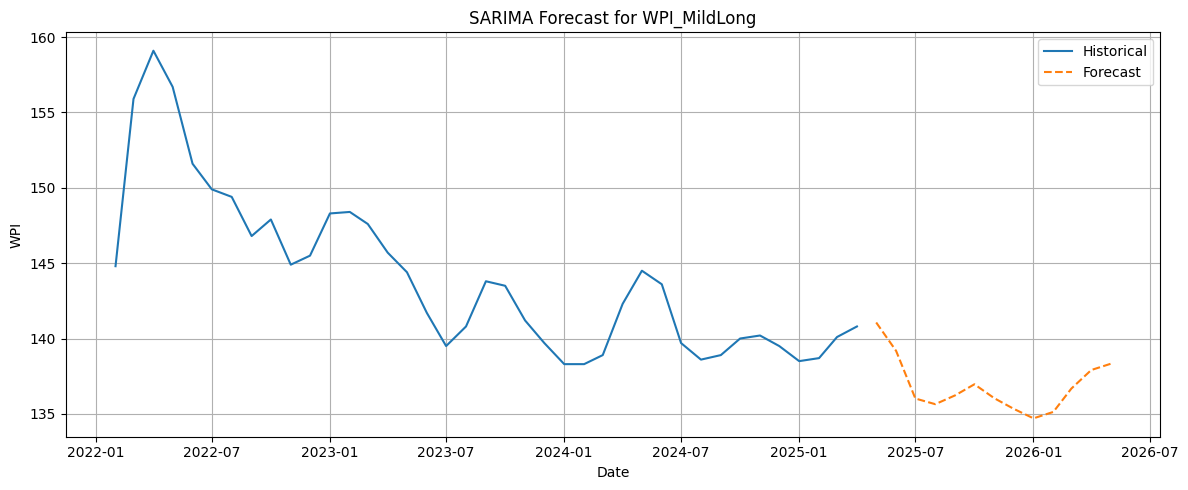

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 📅 Forecast settings
forecast_horizon = 13  # Months: May 2025 to May 2026
targets = ['WPI_Stainless', 'WPI_MildFlat', 'WPI_MildLong']

# 📦 Dictionary to store forecasted values
sarima_forecasts = {}

# 🔮 Fit SARIMA and forecast each WPI
for col in targets:
    print(f"Training SARIMA model for {col}...")

    # Fit SARIMA (seasonal, monthly)
    model = SARIMAX(df[col], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
    results = model.fit(disp=False)

    # Forecast next 13 months
    forecast = results.forecast(steps=forecast_horizon)
    sarima_forecasts[col] = forecast

# 📅 Forecast index (starting from May 2025)
forecast_index = pd.date_range(start='2025-05-01', periods=forecast_horizon, freq='MS')

# 📊 Combine into a DataFrame
sarima_result_df = pd.DataFrame(sarima_forecasts, index=forecast_index)

# 📋 Print forecast table
# print("\n📅 SARIMA Forecast (May 2025 – May 2026):")
# print(sarima_result_df.round(2))

# 📈 Plotting function
def plot_sarima_series(series_name):
    plt.figure(figsize=(12, 5))
    plt.plot(df[series_name], label="Historical")
    plt.plot(sarima_result_df.index, sarima_result_df[series_name], linestyle='--', label="Forecast")
    plt.title(f"SARIMA Forecast for {series_name}")
    plt.xlabel("Date")
    plt.ylabel("WPI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 📈 Plot all three
for col in targets:
    plot_sarima_series(col)


In [ ]:
# 📋 Print forecast table instead of plotting
print("\n📅 SARIMA Forecast Table (May 2025 – May 2026):")
display(sarima_result_df.round(2).head(13))  # or use .to_string() for script

# 🧾 Optional: save to Excel
# sarima_result_df.to_excel("SARIMA_WPI_Forecast.xlsx")



📅 SARIMA Forecast Table (May 2025 – May 2026):


,WPI_Stainless,WPI_MildFlat,WPI_MildLong
2025-05-01,140.34,137.79,141.06
2025-06-01,141.81,136.03,139.18
2025-07-01,138.91,133.87,136.02
2025-08-01,134.88,131.72,135.64
2025-09-01,136.03,129.43,136.23
2025-10-01,135.47,129.43,136.96
2025-11-01,137.36,128.23,136.04
2025-12-01,137.22,126.60,135.34
2026-01-01,136.78,125.52,134.70
2026-02-01,136.20,126.75,135.13


In [ ]:
# 📛 Rename columns if not done already
sarima_result_df = sarima_result_df.rename(columns={
    'WPI_Stainless': 'SARIMA_WPI_Stainless',
    'WPI_MildFlat': 'SARIMA_WPI_MildFlat',
    'WPI_MildLong': 'SARIMA_WPI_MildLong'
})

result_df = result_df.rename(columns={
    'WPI_Stainless_Forecast': 'XGB_WPI_Stainless',
    'WPI_MildFlat_Forecast': 'XGB_WPI_MildFlat',
    'WPI_MildLong_Forecast': 'XGB_WPI_MildLong'
})


In [ ]:
# Combine both into a single DataFrame
hybrid_df = pd.DataFrame(index=sarima_result_df.index)

# For each target, average SARIMA and XGBoost
hybrid_df['Hybrid_WPI_Stainless'] = (
    sarima_result_df['SARIMA_WPI_Stainless'] + result_df['XGB_WPI_Stainless']
) / 2

hybrid_df['Hybrid_WPI_MildFlat'] = (
    sarima_result_df['SARIMA_WPI_MildFlat'] + result_df['XGB_WPI_MildFlat']
) / 2

hybrid_df['Hybrid_WPI_MildLong'] = (
    sarima_result_df['SARIMA_WPI_MildLong'] + result_df['XGB_WPI_MildLong']
) / 2


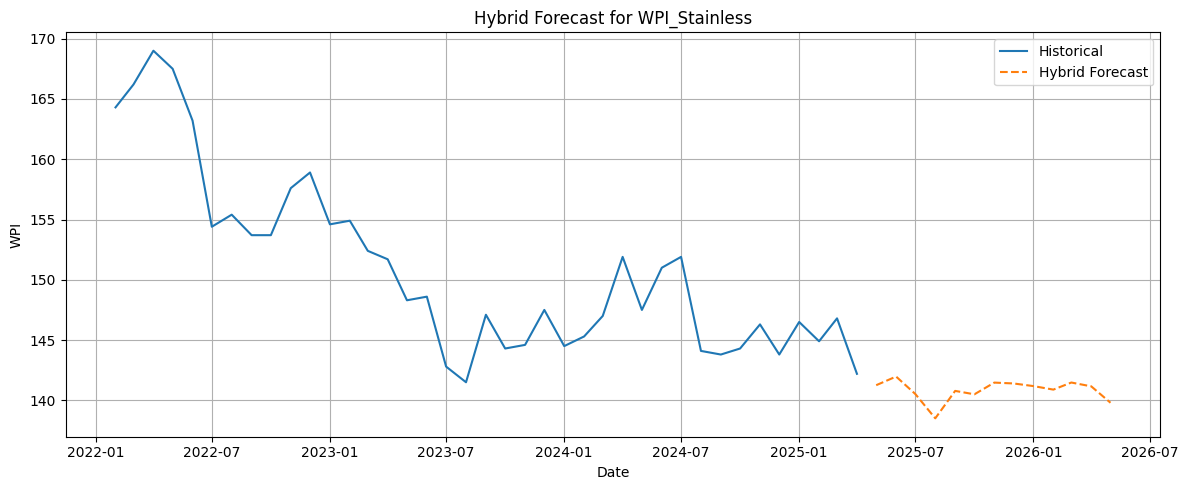

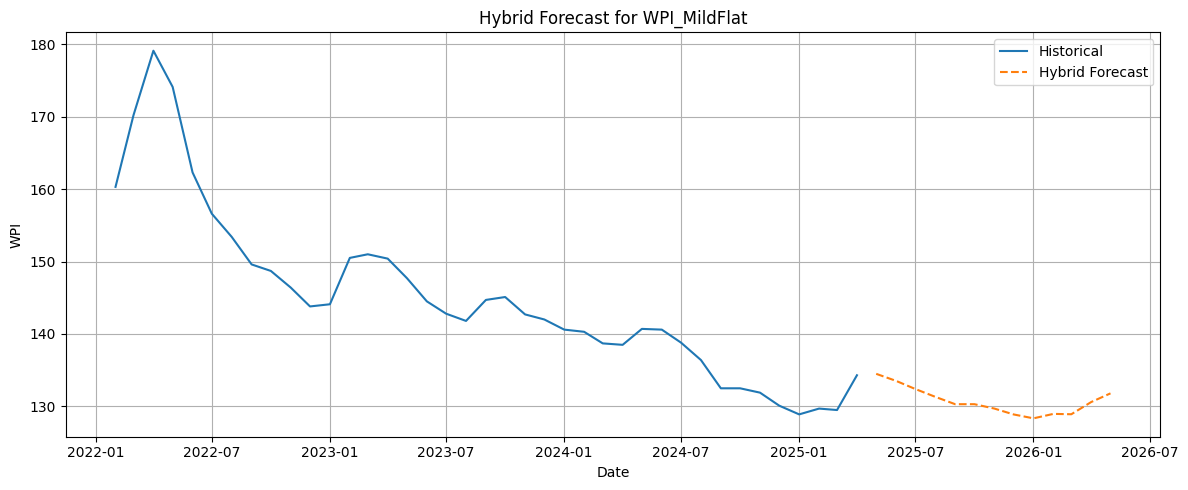

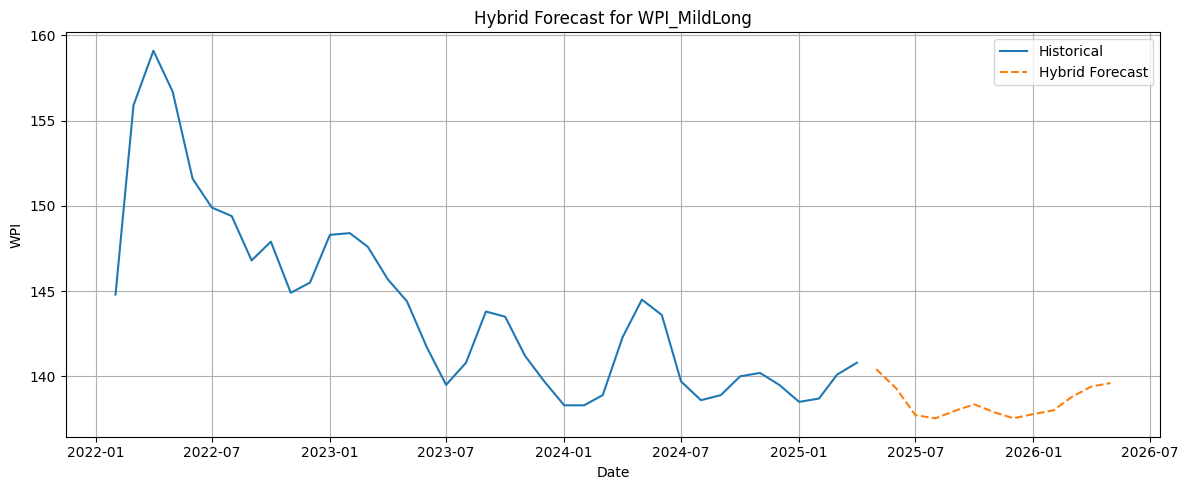

In [ ]:
def plot_hybrid(metric):
    plt.figure(figsize=(12, 5))
    plt.plot(df[metric], label='Historical')
    plt.plot(hybrid_df.index, hybrid_df[f'Hybrid_{metric}'], '--', label='Hybrid Forecast')
    plt.title(f"Hybrid Forecast for {metric}")
    plt.xlabel("Date")
    plt.ylabel("WPI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for all 3
for metric in ['WPI_Stainless', 'WPI_MildFlat', 'WPI_MildLong']:
    plot_hybrid(metric)


In [ ]:
print("🤝 Hybrid Forecasts (SARIMA + XGBoost Average):")
display(hybrid_df.round(2).head(13))


🤝 Hybrid Forecasts (SARIMA + XGBoost Average):


,Hybrid_WPI_Stainless,Hybrid_WPI_MildFlat,Hybrid_WPI_MildLong
2025-05-01,141.26,134.50,140.42
2025-06-01,141.97,133.52,139.30
2025-07-01,140.52,132.40,137.72
2025-08-01,138.51,131.32,137.54
2025-09-01,140.78,130.31,137.99
2025-10-01,140.50,130.31,138.35
2025-11-01,141.47,129.71,137.89
2025-12-01,141.40,128.89,137.54
2026-01-01,141.18,128.35,137.79
2026-02-01,140.89,128.97,138.00
